In [48]:
%load_ext autoreload

In [49]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport Variant_analysis_helper_functions

import subprocess
from scipy.stats import chisquare
import os
import protfasta
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

Steps:
- For every TF find number of iWES gnomAD overlaps in: 
    - AD
    - DBD
    - full TF
- Load in iWES results table for all variants, AD vs DBD 
    - Add gnomAD overlap counts to the table
- Enrichment analysis on variants overlapped with gnomAD

In [52]:
d_domains = "../outputs/mutations/domains_expanded_iWES_v2_variants_snv_classified/"
files = os.listdir(d_domains)
ENST_codes = [f.replace(".bed", "") for f in files]

uniprotID_ENST_mapping = pd.read_csv("../../data/SFARI_TFs_with_ENST.csv")
uniprotID_ENST_mapping = uniprotID_ENST_mapping[["uniprotID", "ENST"]]
uniprotID_ENST_mapping["ENST"] = uniprotID_ENST_mapping["ENST"].str.split(".").str[0]
uniprotID_ENST_mapping_dict= dict(zip(uniprotID_ENST_mapping["ENST"], uniprotID_ENST_mapping["uniprotID"]))
uniprotID_ENST_mapping_dict['ENST00000434704'] = 'O60479'

gnomad = pd.read_csv("../raw_files/gnomad.bed", sep = "\t", header = None)
# gnomad = gnomad[[0, 1, 2, 3, 4]]
gnomad = gnomad.rename(columns = {5 : "gnomad_allele_freq"})
for col_num in [1, 2, "gnomad_allele_freq"]:
    gnomad[col_num] = gnomad[col_num].astype(float)
gnomad[0] = gnomad[0].astype(str)

SFARI_TFs = pd.read_csv("../../data/SFARI_TFs_with_ENST.csv")

In [118]:
def return_iwes_gnomad_overlap(region_type, ENST):
    domain_output = pd.read_csv("../outputs/mutations/" + region_type + "_expanded_iWES_v2_variants_snv_classified/" + ENST + ".bed", sep = "\t", header = None)

    if region_type == "domains":
        domain_output = domain_output[domain_output[22] == "No-Syn"]
        domain_output = domain_output[[0, 1, 2, 17, 18, 19, 3]]
        domain_output = domain_output.rename(columns = {17: 3, 18: 4, 19: "iWES_allele_freq", 3: "domain_type"})
    else:
        domain_output = domain_output[domain_output[14] == "No-Syn"]
        domain_output = domain_output[[0, 1, 2, 9, 10, 11]]
        domain_output = domain_output.rename(columns = {9: 3, 10: 4, 11: "iWES_allele_freq"})
        domain_output["domain_type"] = "cds"
    for col_num in [1, 2, "iWES_allele_freq"]:
        domain_output[col_num] = domain_output[col_num].astype(float)
    domain_output[0] = domain_output[0].astype(str)
    display(domain_output)
    
    gnomad_iwes_overlap = pd.merge(domain_output, gnomad, on = [0, 1,2, 3, 4], how = "inner")
    return gnomad_iwes_overlap

def return_iWES_minus_gnomad_counts(region_type, ENST):
    if region_type == "cds":
        gnomad_iwes_overlap = return_iwes_gnomad_overlap("cds", ENST)
        return len(gnomad_iwes_overlap)
    else:
        gnomad_iwes_overlap = return_iwes_gnomad_overlap("domains", ENST)
        AD_counts = len(gnomad_iwes_overlap[gnomad_iwes_overlap["domain_type"] == "AD"])
        DBD_counts = len(gnomad_iwes_overlap[gnomad_iwes_overlap["domain_type"] == "DBD"])
        return (AD_counts, DBD_counts)

In [119]:
AD_overlaps, DBD_overlaps, TF_overlaps = [], [], []
for ENST in ENST_codes:
    domains_counts = return_iWES_minus_gnomad_counts("domains", ENST)
    AD_overlaps.append(domains_counts[0])
    DBD_overlaps.append(domains_counts[1])
    TF_overlaps.append(return_iWES_minus_gnomad_counts("cds", ENST))

,0,1,2,3,4,iWES_allele_freq,domain_type
0,18,55461053.0,55461054.0,T,C,0.000436,AD
1,18,55461063.0,55461064.0,A,G,0.000019,AD
2,18,55461077.0,55461078.0,C,A,0.000005,AD
3,18,55461082.0,55461083.0,C,T,0.000056,AD
4,18,55461085.0,55461086.0,G,C,0.000005,AD
5,18,55461087.0,55461088.0,G,C,0.000005,AD
6,18,55461089.0,55461090.0,T,C,0.000005,AD
7,18,55461092.0,55461093.0,T,C,0.000009,AD
10,18,55461099.0,55461100.0,T,C,0.000042,AD
12,18,55461110.0,55461111.0,T,C,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,18,55228236.0,55228237.0,C,A,0.000005,cds
3,18,55228250.0,55228251.0,C,T,0.000009,cds
6,18,55228274.0,55228275.0,C,T,0.000009,cds
8,18,55228282.0,55228283.0,G,A,0.000005,cds
9,18,55228288.0,55228289.0,G,A,0.000009,cds
...,...,...,...,...,...,...,...
284,18,55464089.0,55464090.0,G,A,0.000005,cds
287,18,55464100.0,55464101.0,T,C,0.000131,cds
288,18,55464115.0,55464116.0,G,A,0.000005,cds
289,18,55464118.0,55464119.0,C,T,0.000014,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,17,4981779.0,4981780.0,A,G,0.000014,DBD
1,17,4981780.0,4981781.0,G,C,0.000014,DBD
7,17,4981818.0,4981819.0,C,T,0.000009,DBD
10,17,4981822.0,4981823.0,G,C,0.000009,DBD
11,17,4981824.0,4981825.0,C,G,0.000009,DBD
...,...,...,...,...,...,...,...
254,17,4979898.0,4979899.0,G,C,0.000005,AD
257,17,4979903.0,4979904.0,G,A,0.000005,AD
258,17,4979907.0,4979908.0,A,G,0.000028,AD
259,17,4979907.0,4979908.0,A,C,0.000028,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
4,17,4968793.0,4968794.0,C,G,0.000431,cds
5,17,4968795.0,4968796.0,T,C,0.000009,cds
7,17,4968798.0,4968799.0,T,C,0.000009,cds
8,17,4968807.0,4968808.0,A,C,0.000084,cds
10,17,4968815.0,4968816.0,C,T,0.000023,cds
...,...,...,...,...,...,...,...
760,17,4986202.0,4986203.0,G,A,0.000037,cds
761,17,4986206.0,4986207.0,T,C,0.000005,cds
762,17,4986209.0,4986210.0,C,T,0.000009,cds
763,17,4986217.0,4986218.0,T,G,0.000033,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,X,25007408.0,25007409.0,G,A,0.000005,DBD
3,X,25010266.0,25010267.0,C,T,0.000033,DBD
14,X,25013007.0,25013008.0,C,G,0.000061,DBD
22,X,25004732.0,25004733.0,G,C,0.000019,AD
23,X,25004740.0,25004741.0,T,C,0.000052,AD
31,X,25004773.0,25004774.0,C,T,0.000014,AD
33,X,25004784.0,25004785.0,G,A,0.000019,AD
34,X,25004785.0,25004786.0,C,A,0.000009,AD
38,X,25004793.0,25004794.0,G,C,0.000009,AD
39,X,25004797.0,25004798.0,C,T,0.000052,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
6,X,25004732.0,25004733.0,G,C,0.000019,cds
7,X,25004740.0,25004741.0,T,C,0.000052,cds
15,X,25004773.0,25004774.0,C,T,0.000014,cds
17,X,25004784.0,25004785.0,G,A,0.000019,cds
18,X,25004785.0,25004786.0,C,A,0.000009,cds
...,...,...,...,...,...,...,...
352,X,25015636.0,25015637.0,C,G,0.000014,cds
354,X,25015646.0,25015647.0,T,G,0.000098,cds
356,X,25015668.0,25015669.0,C,A,0.000005,cds
358,X,25015712.0,25015713.0,C,T,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,17,40096081.0,40096082.0,G,A,0.000014,DBD
3,17,40096462.0,40096463.0,G,A,0.000009,DBD
5,17,40096468.0,40096469.0,C,G,0.000014,DBD
10,17,40096502.0,40096503.0,G,A,0.000014,DBD
11,17,40096505.0,40096506.0,T,G,0.000005,DBD
...,...,...,...,...,...,...,...
206,17,40097327.0,40097328.0,T,C,0.000023,AD
213,17,40097354.0,40097355.0,G,A,0.000047,AD
219,17,40097384.0,40097385.0,A,G,0.000023,AD
221,17,40097390.0,40097391.0,G,A,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,17,40093089.0,40093090.0,G,A,0.000009,cds
2,17,40093091.0,40093092.0,G,T,0.000009,cds
3,17,40093095.0,40093096.0,A,C,0.000009,cds
4,17,40093098.0,40093099.0,C,T,0.000005,cds
5,17,40093099.0,40093100.0,G,A,0.000014,cds
...,...,...,...,...,...,...,...
425,17,40097384.0,40097385.0,A,G,0.000023,cds
427,17,40097390.0,40097391.0,G,A,0.000009,cds
428,17,40097397.0,40097398.0,C,T,0.000009,cds
431,17,40100089.0,40100090.0,G,A,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,1,53506626.0,53506627.0,C,T,0.000009,AD
3,1,53506629.0,53506630.0,T,C,0.000028,AD
4,1,53506632.0,53506633.0,A,G,0.000005,AD
5,1,53506637.0,53506638.0,G,A,0.000005,AD
6,1,53506640.0,53506641.0,G,A,0.000014,AD
...,...,...,...,...,...,...,...
111,1,53514627.0,53514628.0,T,C,0.000014,AD
113,1,53514630.0,53514631.0,C,T,0.000037,AD
114,1,53514630.0,53514631.0,C,A,0.000005,AD
115,1,53514631.0,53514632.0,G,A,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,1,53506626.0,53506627.0,C,T,0.000009,cds
3,1,53506629.0,53506630.0,T,C,0.000028,cds
4,1,53506632.0,53506633.0,A,G,0.000005,cds
5,1,53506637.0,53506638.0,G,A,0.000005,cds
6,1,53506640.0,53506641.0,G,A,0.000014,cds
...,...,...,...,...,...,...,...
480,1,53594867.0,53594868.0,C,G,0.000009,cds
481,1,53594877.0,53594878.0,A,T,0.000014,cds
482,1,53594888.0,53594889.0,C,T,0.000033,cds
483,1,53594889.0,53594890.0,G,A,0.000014,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
3,8,22691017.0,22691018.0,G,C,0.000005,AD
4,8,22691018.0,22691019.0,A,C,0.000037,AD
6,8,22691020.0,22691021.0,T,A,0.000014,AD
7,8,22691022.0,22691023.0,G,A,0.000009,AD
8,8,22691023.0,22691024.0,A,C,0.000005,AD
...,...,...,...,...,...,...,...
126,8,22692853.0,22692854.0,T,C,0.000005,AD
127,8,22692865.0,22692866.0,C,T,0.000005,AD
130,8,22692868.0,22692869.0,G,A,0.000005,AD
133,8,22692890.0,22692891.0,G,C,0.000014,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,8,22690489.0,22690490.0,C,T,0.000005,cds
10,8,22690512.0,22690513.0,G,A,0.000009,cds
11,8,22690513.0,22690514.0,G,C,0.000070,cds
12,8,22690513.0,22690514.0,G,T,0.000005,cds
13,8,22690515.0,22690516.0,G,A,0.000005,cds
...,...,...,...,...,...,...,...
266,8,22692890.0,22692891.0,G,C,0.000014,cds
268,8,22692905.0,22692906.0,C,T,0.000009,cds
270,8,22692915.0,22692916.0,G,A,0.000005,cds
272,8,22692928.0,22692929.0,C,A,0.000023,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,7,26183703.0,26183704.0,C,G,0.000033,AD
1,7,26183703.0,26183704.0,C,T,0.000005,AD
2,7,26183704.0,26183705.0,A,G,0.000023,AD
3,7,26183718.0,26183719.0,G,C,0.000005,AD
7,7,26183760.0,26183761.0,T,C,0.000033,AD
...,...,...,...,...,...,...,...
131,7,26185038.0,26185039.0,A,G,0.000009,AD
132,7,26185039.0,26185040.0,G,A,0.000009,AD
133,7,26185040.0,26185041.0,G,T,0.000089,AD
135,7,26185046.0,26185047.0,G,A,0.000066,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,7,26152514.0,26152515.0,G,C,0.000019,cds
1,7,26152514.0,26152515.0,G,A,0.000009,cds
2,7,26152514.0,26152515.0,G,T,0.000009,cds
4,7,26152523.0,26152524.0,C,G,0.000019,cds
5,7,26152528.0,26152529.0,G,A,0.000009,cds
...,...,...,...,...,...,...,...
502,7,26185757.0,26185758.0,A,C,0.000009,cds
504,7,26185762.0,26185763.0,C,G,0.000005,cds
506,7,26185775.0,26185776.0,G,C,0.000028,cds
507,7,26185777.0,26185778.0,A,C,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
6,15,60514691.0,60514692.0,C,A,0.000005,DBD
8,15,60514698.0,60514699.0,T,C,0.000014,DBD
13,15,60514728.0,60514729.0,T,A,0.000005,DBD
14,15,60514729.0,60514730.0,T,A,0.000005,DBD
15,15,60514742.0,60514743.0,T,A,0.000005,DBD
20,15,60502789.0,60502790.0,A,G,0.000033,AD
23,15,60502807.0,60502808.0,C,T,0.000019,AD
26,15,60502822.0,60502823.0,A,G,0.000014,AD
39,15,60503621.0,60503622.0,C,T,0.000005,AD
42,15,60503636.0,60503637.0,T,C,0.000042,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
3,15,60497476.0,60497477.0,G,C,0.000009,cds
4,15,60497482.0,60497483.0,A,T,0.000005,cds
7,15,60497508.0,60497509.0,T,A,0.000215,cds
9,15,60497521.0,60497522.0,T,C,0.000005,cds
11,15,60497533.0,60497534.0,A,G,0.000005,cds
...,...,...,...,...,...,...,...
305,15,61229190.0,61229191.0,G,C,0.000009,cds
308,15,61229198.0,61229199.0,G,A,0.000028,cds
310,15,61229202.0,61229203.0,C,T,0.000023,cds
311,15,61229207.0,61229208.0,G,C,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,15,80576923.0,80576924.0,A,C,0.000009,AD
3,15,80576937.0,80576938.0,C,G,0.000009,AD
4,15,80576939.0,80576940.0,T,C,0.000028,AD
5,15,80576940.0,80576941.0,C,A,0.000033,AD
8,15,80576951.0,80576952.0,G,A,0.000019,AD
11,15,80580432.0,80580433.0,G,A,0.000023,AD
12,15,80580435.0,80580436.0,G,C,0.000009,AD
14,15,80580456.0,80580457.0,T,C,0.000009,AD
15,15,80580463.0,80580464.0,C,T,0.000042,AD
18,15,80580490.0,80580491.0,G,A,0.000019,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,15,80404516.0,80404517.0,T,C,0.000005,cds
1,15,80404522.0,80404523.0,C,A,0.000028,cds
4,15,80404525.0,80404526.0,C,G,0.000009,cds
6,15,80404542.0,80404543.0,C,T,0.000225,cds
9,15,80450900.0,80450901.0,G,A,0.000005,cds
...,...,...,...,...,...,...,...
378,15,80591683.0,80591684.0,G,A,0.178136,cds
379,15,80591686.0,80591687.0,C,G,0.000009,cds
381,15,80593618.0,80593619.0,G,A,0.000009,cds
383,15,80593626.0,80593627.0,A,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,1,37815544.0,37815545.0,C,T,0.000009,AD
1,1,37815560.0,37815561.0,A,C,0.000005,AD
2,1,37815563.0,37815564.0,T,A,0.000005,AD
4,1,37817421.0,37817422.0,G,T,0.000005,AD
7,1,37817457.0,37817458.0,C,G,0.000028,AD
...,...,...,...,...,...,...,...
154,1,37832249.0,37832250.0,T,C,0.000009,AD
156,1,37832260.0,37832261.0,C,T,0.000009,AD
158,1,37832273.0,37832274.0,C,T,0.000009,AD
159,1,37832281.0,37832282.0,A,G,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,1,37815145.0,37815146.0,A,T,0.000005,cds
2,1,37815167.0,37815168.0,C,T,0.000009,cds
3,1,37815170.0,37815171.0,C,T,0.000005,cds
7,1,37815175.0,37815176.0,C,A,0.000066,cds
8,1,37815175.0,37815176.0,C,T,0.000019,cds
...,...,...,...,...,...,...,...
402,1,37857624.0,37857625.0,A,T,0.000005,cds
403,1,37857626.0,37857627.0,A,C,0.000037,cds
404,1,37857632.0,37857633.0,T,C,0.000052,cds
406,1,37857649.0,37857650.0,T,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,22,42210666.0,42210667.0,C,T,0.000014,DBD
3,22,42210673.0,42210674.0,A,C,0.000005,DBD
4,22,42214325.0,42214326.0,T,C,0.000014,AD
5,22,42214327.0,42214328.0,C,G,0.000014,AD
6,22,42214329.0,42214330.0,G,C,0.000009,AD
...,...,...,...,...,...,...,...
200,22,42215258.0,42215259.0,C,G,0.013598,AD
203,22,42215271.0,42215272.0,C,T,0.000009,AD
205,22,42215287.0,42215288.0,C,A,0.000009,AD
206,22,42215291.0,42215292.0,C,T,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,22,42168659.0,42168660.0,C,T,0.000061,cds
1,22,42168660.0,42168661.0,G,A,0.000009,cds
3,22,42168667.0,42168668.0,C,A,0.000005,cds
4,22,42168678.0,42168679.0,T,A,0.000192,cds
5,22,42168686.0,42168687.0,C,G,0.000019,cds
...,...,...,...,...,...,...,...
1272,22,42215258.0,42215259.0,C,G,0.013598,cds
1275,22,42215271.0,42215272.0,C,T,0.000009,cds
1277,22,42215287.0,42215288.0,C,A,0.000009,cds
1278,22,42215291.0,42215292.0,C,T,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,11,118472101.0,118472102.0,C,G,0.000009,DBD
2,11,118472104.0,118472105.0,T,G,0.000023,DBD
5,11,118472107.0,118472108.0,G,C,0.000014,DBD
7,11,118472121.0,118472122.0,T,A,0.000005,DBD
10,11,118504709.0,118504710.0,C,T,0.000009,AD
11,11,118504715.0,118504716.0,C,T,0.000009,AD
12,11,118504722.0,118504723.0,T,C,0.000005,AD
13,11,118504731.0,118504732.0,A,C,0.000009,AD
15,11,118504748.0,118504749.0,G,C,0.000009,AD
18,11,118504800.0,118504801.0,T,C,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,11,118436522.0,118436523.0,G,A,0.000005,cds
4,11,118436572.0,118436573.0,G,A,0.000005,cds
6,11,118436576.0,118436577.0,G,C,0.000019,cds
10,11,118436593.0,118436594.0,G,T,0.000023,cds
13,11,118436620.0,118436621.0,G,T,0.000005,cds
...,...,...,...,...,...,...,...
1876,11,118522017.0,118522018.0,A,T,0.000009,cds
1882,11,118522076.0,118522077.0,G,A,0.000005,cds
1889,11,118522142.0,118522143.0,G,A,0.000014,cds
1890,11,118522155.0,118522156.0,G,A,0.000075,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,X,49034144.0,49034145.0,C,A,0.000019,AD
8,X,49034213.0,49034214.0,C,T,0.000267,AD
9,X,49034216.0,49034217.0,C,T,0.000023,AD
10,X,49034224.0,49034225.0,A,T,0.000009,AD
12,X,49038014.0,49038015.0,T,A,0.000005,AD
...,...,...,...,...,...,...,...
174,X,49043175.0,49043176.0,C,A,0.000009,AD
175,X,49043180.0,49043181.0,C,T,0.000028,AD
178,X,49043200.0,49043201.0,C,T,0.000061,AD
179,X,49043200.0,49043201.0,C,G,0.000319,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,X,49030169.0,49030170.0,T,G,0.000014,cds
3,X,49030176.0,49030177.0,C,T,0.000005,cds
4,X,49030189.0,49030190.0,G,A,0.000080,cds
5,X,49030192.0,49030193.0,G,A,0.000009,cds
8,X,49030212.0,49030213.0,G,A,0.000155,cds
...,...,...,...,...,...,...,...
268,X,49043175.0,49043176.0,C,A,0.000009,cds
269,X,49043180.0,49043181.0,C,T,0.000028,cds
272,X,49043200.0,49043201.0,C,T,0.000061,cds
273,X,49043200.0,49043201.0,C,G,0.000319,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,1,10660486.0,10660487.0,G,T,0.000005,AD
1,1,10660489.0,10660490.0,C,G,0.000005,AD
6,1,10660508.0,10660509.0,G,A,0.000014,AD
7,1,10660509.0,10660510.0,C,T,0.000005,AD
8,1,10660511.0,10660512.0,T,C,0.000009,AD
...,...,...,...,...,...,...,...
132,1,10665468.0,10665469.0,C,T,0.000005,AD
133,1,10665469.0,10665470.0,G,A,0.000009,AD
134,1,10665472.0,10665473.0,T,G,0.000005,AD
135,1,10665481.0,10665482.0,C,T,0.000023,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,1,10638949.0,10638950.0,A,T,0.000014,cds
6,1,10638961.0,10638962.0,T,C,0.000005,cds
8,1,10638963.0,10638964.0,G,C,0.000009,cds
9,1,10638963.0,10638964.0,G,A,0.000005,cds
10,1,10638964.0,10638965.0,G,A,0.000009,cds
...,...,...,...,...,...,...,...
1357,1,10665552.0,10665553.0,G,A,0.000033,cds
1358,1,10665553.0,10665554.0,T,A,0.000005,cds
1359,1,10665558.0,10665559.0,C,T,0.000023,cds
1360,1,10665559.0,10665560.0,G,A,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,5,135029283.0,135029284.0,C,T,0.000005,DBD
6,5,135029290.0,135029291.0,G,T,0.000019,DBD
11,5,135029320.0,135029321.0,C,T,0.000009,DBD
13,5,135031283.0,135031284.0,G,A,0.000023,DBD
15,5,135031289.0,135031290.0,C,T,0.000009,DBD
25,5,135031342.0,135031343.0,C,G,0.000009,DBD
27,5,135031361.0,135031362.0,C,T,0.000019,DBD
32,5,135031381.0,135031382.0,T,C,0.000005,DBD
38,5,135031405.0,135031406.0,C,T,0.000005,DBD
39,5,135031406.0,135031407.0,G,A,0.000005,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,5,135028783.0,135028784.0,T,C,0.000009,cds
3,5,135028797.0,135028798.0,G,T,0.000009,cds
4,5,135028798.0,135028799.0,C,A,0.000009,cds
6,5,135028812.0,135028813.0,G,T,0.000009,cds
9,5,135028815.0,135028816.0,G,A,0.000009,cds
...,...,...,...,...,...,...,...
256,5,135033865.0,135033866.0,C,T,0.000019,cds
258,5,135033873.0,135033874.0,G,A,0.000005,cds
259,5,135033877.0,135033878.0,C,T,0.000014,cds
260,5,135033879.0,135033880.0,A,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,20,21512188.0,21512189.0,C,A,0.000005,DBD
3,20,21512191.0,21512192.0,G,C,0.000005,DBD
12,20,21512241.0,21512242.0,G,A,0.000005,DBD
15,20,21512247.0,21512248.0,C,T,0.000023,DBD
19,20,21512259.0,21512260.0,G,C,0.000005,DBD
22,20,21512271.0,21512272.0,C,T,0.000009,DBD
23,20,21512272.0,21512273.0,G,T,0.000136,DBD
25,20,21512275.0,21512276.0,C,G,0.000005,DBD
36,20,21512308.0,21512309.0,G,A,0.000009,DBD
37,20,21512308.0,21512309.0,G,T,0.000009,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,20,21511924.0,21511925.0,A,T,0.000005,cds
1,20,21511935.0,21511936.0,T,G,0.000005,cds
2,20,21511942.0,21511943.0,C,A,0.000005,cds
4,20,21511948.0,21511949.0,C,A,0.000009,cds
7,20,21511954.0,21511955.0,G,C,0.000019,cds
...,...,...,...,...,...,...,...
253,20,21513595.0,21513596.0,T,G,0.000009,cds
254,20,21513599.0,21513600.0,C,T,0.000009,cds
256,20,21513613.0,21513614.0,G,A,0.000009,cds
257,20,21513613.0,21513614.0,G,C,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,15,36950344.0,36950345.0,G,C,0.000009,DBD
9,15,37036815.0,37036816.0,T,G,0.000014,DBD
12,15,37036842.0,37036843.0,T,G,0.000005,DBD
13,15,37036868.0,37036869.0,A,C,0.000005,DBD
19,15,37036886.0,37036887.0,C,T,0.000009,DBD
...,...,...,...,...,...,...,...
108,15,36895168.0,36895169.0,T,G,0.000136,AD
111,15,36895180.0,36895181.0,C,T,0.000037,AD
115,15,36895228.0,36895229.0,C,T,0.000023,AD
117,15,36895246.0,36895247.0,G,A,0.000023,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,15,36892176.0,36892177.0,T,C,0.000005,cds
2,15,36892182.0,36892183.0,T,C,0.000052,cds
4,15,36892190.0,36892191.0,C,T,0.000005,cds
5,15,36892191.0,36892192.0,A,G,0.000037,cds
6,15,36892196.0,36892197.0,C,A,0.000014,cds
...,...,...,...,...,...,...,...
296,15,37098182.0,37098183.0,T,C,0.000005,cds
298,15,37098190.0,37098191.0,C,G,0.000033,cds
299,15,37098193.0,37098194.0,A,T,0.000005,cds
301,15,37098193.0,37098194.0,A,C,0.000019,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
3,2,156328423.0,156328424.0,G,A,0.000005,DBD
5,2,156328445.0,156328446.0,A,G,0.000005,DBD
8,2,156328463.0,156328464.0,G,A,0.000005,DBD
10,2,156328469.0,156328470.0,G,T,0.000009,DBD
12,2,156328495.0,156328496.0,G,A,0.000019,DBD
15,2,156328504.0,156328505.0,A,G,0.000009,DBD
23,2,156329365.0,156329366.0,T,C,0.000005,DBD
26,2,156329380.0,156329381.0,T,C,0.000005,DBD
31,2,156329398.0,156329399.0,C,T,0.000005,DBD
33,2,156329929.0,156329930.0,T,C,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,2,156325771.0,156325772.0,T,C,0.000005,cds
2,2,156325774.0,156325775.0,T,C,0.000005,cds
4,2,156325780.0,156325781.0,A,T,0.000009,cds
6,2,156325793.0,156325794.0,G,C,0.000005,cds
11,2,156325828.0,156325829.0,T,C,0.000005,cds
...,...,...,...,...,...,...,...
337,2,156330116.0,156330117.0,A,T,0.000005,cds
342,2,156330137.0,156330138.0,G,C,0.000009,cds
346,2,156330157.0,156330158.0,G,C,0.000023,cds
347,2,156330163.0,156330164.0,T,C,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,14,100239244.0,100239245.0,A,C,0.000323,AD
1,14,100239245.0,100239246.0,T,A,0.000070,AD
2,14,100239245.0,100239246.0,T,G,0.000014,AD
3,14,100239250.0,100239251.0,T,G,0.000047,AD
4,14,100239250.0,100239251.0,T,A,0.000009,AD
7,14,100239263.0,100239264.0,T,A,0.000159,AD
9,14,100239265.0,100239266.0,T,A,0.000019,AD
10,14,100239269.0,100239270.0,T,A,0.000014,AD
15,14,100239291.0,100239292.0,G,A,0.000019,AD
16,14,100239300.0,100239301.0,G,C,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,14,100239244.0,100239245.0,A,C,0.000323,cds
1,14,100239245.0,100239246.0,T,A,0.000070,cds
2,14,100239245.0,100239246.0,T,G,0.000014,cds
3,14,100239250.0,100239251.0,T,G,0.000047,cds
4,14,100239250.0,100239251.0,T,A,0.000009,cds
...,...,...,...,...,...,...,...
206,14,100276607.0,100276608.0,A,C,0.000009,cds
210,14,100276640.0,100276641.0,C,A,0.000005,cds
218,14,100277466.0,100277467.0,G,A,0.000005,cds
219,14,100277468.0,100277469.0,A,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,2,1922495.0,1922496.0,C,T,0.000005,AD
1,2,1922501.0,1922502.0,C,A,0.000005,AD
7,2,1922547.0,1922548.0,C,A,0.000005,AD
11,2,1922557.0,1922558.0,C,A,0.000005,AD
12,2,1922557.0,1922558.0,C,G,0.000005,AD
...,...,...,...,...,...,...,...
142,2,1923225.0,1923226.0,C,T,0.000005,AD
143,2,1923226.0,1923227.0,A,C,0.000023,AD
145,2,1923239.0,1923240.0,T,C,0.000056,AD
146,2,1923241.0,1923242.0,T,C,0.000014,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,2,1791879.0,1791880.0,C,G,0.000005,cds
1,2,1791880.0,1791881.0,C,T,0.000019,cds
2,2,1791883.0,1791884.0,T,C,0.000019,cds
5,2,1791914.0,1791915.0,T,G,0.000005,cds
7,2,1791927.0,1791928.0,C,T,0.000009,cds
...,...,...,...,...,...,...,...
570,2,1979761.0,1979762.0,C,T,0.000009,cds
573,2,1979764.0,1979765.0,T,C,0.000037,cds
574,2,1979767.0,1979768.0,C,T,0.000005,cds
575,2,1979769.0,1979770.0,A,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
5,5,88804628.0,88804629.0,T,G,0.000005,DBD
17,5,88722626.0,88722627.0,G,A,0.000009,AD
24,5,88722688.0,88722689.0,G,T,0.000005,AD
27,5,88722694.0,88722695.0,T,G,0.000009,AD
34,5,88722727.0,88722728.0,C,T,0.000005,AD
40,5,88722763.0,88722764.0,A,G,0.000009,AD
42,5,88722778.0,88722779.0,G,A,0.000009,AD
44,5,88722790.0,88722791.0,G,A,0.000009,AD
48,5,88722818.0,88722819.0,T,C,0.000023,AD
49,5,88722823.0,88722824.0,C,T,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
4,5,88722626.0,88722627.0,G,A,0.000009,cds
11,5,88722688.0,88722689.0,G,T,0.000005,cds
14,5,88722694.0,88722695.0,T,G,0.000009,cds
21,5,88722727.0,88722728.0,C,T,0.000005,cds
27,5,88722763.0,88722764.0,A,G,0.000009,cds
...,...,...,...,...,...,...,...
208,5,88804797.0,88804798.0,T,C,0.000005,cds
209,5,88823745.0,88823746.0,G,A,0.000005,cds
210,5,88823754.0,88823755.0,T,C,0.000005,cds
212,5,88823774.0,88823775.0,T,C,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,X,80023176.0,80023177.0,G,T,0.000014,DBD
2,X,80023185.0,80023186.0,T,A,0.000262,DBD
3,X,80023194.0,80023195.0,G,C,0.000009,DBD
4,X,80023208.0,80023209.0,G,A,0.000005,DBD
10,X,80024073.0,80024074.0,C,T,0.000014,DBD
...,...,...,...,...,...,...,...
93,X,80030934.0,80030935.0,G,A,0.000009,AD
94,X,80030941.0,80030942.0,G,A,0.000009,AD
96,X,80030954.0,80030955.0,T,A,0.000005,AD
97,X,80030971.0,80030972.0,A,T,0.000300,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,X,80022282.0,80022283.0,C,G,0.000009,cds
1,X,80022287.0,80022288.0,G,A,0.000023,cds
3,X,80022290.0,80022291.0,C,T,0.000042,cds
4,X,80022291.0,80022292.0,G,A,0.000014,cds
5,X,80022299.0,80022300.0,T,A,0.000014,cds
...,...,...,...,...,...,...,...
187,X,80031061.0,80031062.0,G,T,0.000014,cds
189,X,80031066.0,80031067.0,T,C,0.000056,cds
190,X,80031083.0,80031084.0,G,C,0.000028,cds
191,X,80031091.0,80031092.0,C,A,0.000084,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,11,31800834.0,31800835.0,G,A,0.000005,DBD
1,11,31800836.0,31800837.0,A,G,0.000005,DBD
4,11,31801586.0,31801587.0,C,A,0.000009,DBD
6,11,31801592.0,31801593.0,C,T,0.000005,DBD
16,11,31801622.0,31801623.0,C,A,0.000005,DBD
21,11,31801660.0,31801661.0,T,C,0.000009,DBD
22,11,31801672.0,31801673.0,T,G,0.000019,DBD
41,11,31802751.0,31802752.0,C,G,0.000005,DBD
43,11,31802756.0,31802757.0,C,T,0.000005,DBD
45,11,31802763.0,31802764.0,C,G,0.000005,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,11,31789936.0,31789937.0,C,A,0.004122,cds
1,11,31789936.0,31789937.0,C,G,0.000206,cds
3,11,31789937.0,31789938.0,T,C,0.000019,cds
4,11,31789937.0,31789938.0,T,G,0.000009,cds
5,11,31789938.0,31789939.0,G,T,0.001869,cds
...,...,...,...,...,...,...,...
206,11,31802756.0,31802757.0,C,T,0.000005,cds
208,11,31802763.0,31802764.0,C,G,0.000005,cds
209,11,31802764.0,31802765.0,T,C,0.000009,cds
212,11,31802779.0,31802780.0,G,A,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,1,41581582.0,41581583.0,G,A,0.000005,AD
2,1,41581586.0,41581587.0,C,G,0.000014,AD
3,1,41581589.0,41581590.0,C,T,0.000023,AD
5,1,41581591.0,41581592.0,C,T,0.000009,AD
6,1,41581592.0,41581593.0,T,A,0.000009,AD
...,...,...,...,...,...,...,...
538,1,41584073.0,41584074.0,G,A,0.000009,AD
545,1,41584116.0,41584117.0,G,C,0.000005,AD
546,1,41584130.0,41584131.0,C,T,0.000009,AD
549,1,41584153.0,41584154.0,G,A,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,1,41510457.0,41510458.0,T,G,0.000005,cds
2,1,41510460.0,41510461.0,G,C,0.007616,cds
3,1,41510463.0,41510464.0,G,T,0.000014,cds
4,1,41510463.0,41510464.0,G,A,0.000005,cds
5,1,41510464.0,41510465.0,G,A,0.000005,cds
...,...,...,...,...,...,...,...
1597,1,41584744.0,41584745.0,C,T,0.000009,cds
1598,1,41584745.0,41584746.0,G,A,0.000023,cds
1600,1,41584760.0,41584761.0,C,T,0.001241,cds
1601,1,41584760.0,41584761.0,C,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,12,47865048.0,47865049.0,T,G,0.000019,DBD
2,12,47865049.0,47865050.0,C,T,0.000009,DBD
5,12,47865064.0,47865065.0,T,C,0.000042,DBD
8,12,47865075.0,47865076.0,C,T,0.000005,DBD
9,12,47865076.0,47865077.0,G,A,0.000005,DBD
12,12,47865084.0,47865085.0,C,T,0.000023,DBD
14,12,47865087.0,47865088.0,C,T,0.000019,DBD
16,12,47865102.0,47865103.0,C,T,0.000019,DBD
17,12,47865103.0,47865104.0,G,A,0.000019,DBD
22,12,47865111.0,47865112.0,T,C,0.000061,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,12,47844749.0,47844750.0,G,A,0.000005,cds
1,12,47844758.0,47844759.0,T,C,0.000005,cds
12,12,47844792.0,47844793.0,T,G,0.000037,cds
13,12,47844800.0,47844801.0,C,T,0.000037,cds
14,12,47844801.0,47844802.0,A,G,0.000037,cds
...,...,...,...,...,...,...,...
314,12,47879090.0,47879091.0,G,C,0.000005,cds
317,12,47879103.0,47879104.0,T,C,0.000023,cds
318,12,47879105.0,47879106.0,G,T,0.000080,cds
320,12,47879110.0,47879111.0,C,T,0.000019,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,1,61088165.0,61088166.0,C,G,0.000014,DBD
5,1,61088187.0,61088188.0,G,A,0.000005,DBD
6,1,61088187.0,61088188.0,G,C,0.000014,DBD
7,1,61088191.0,61088192.0,G,A,0.000005,DBD
13,1,61088259.0,61088260.0,C,T,0.000014,DBD
18,1,61088286.0,61088287.0,G,A,0.000005,DBD
20,1,61088306.0,61088307.0,T,G,0.000033,DBD
21,1,61088314.0,61088315.0,C,T,0.000023,DBD
22,1,61088319.0,61088320.0,G,A,0.000005,DBD
31,1,61088358.0,61088359.0,C,T,0.000009,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,1,61082804.0,61082805.0,T,A,0.000009,cds
3,1,61082810.0,61082811.0,T,A,0.000009,cds
5,1,61088165.0,61088166.0,C,G,0.000014,cds
9,1,61088187.0,61088188.0,G,A,0.000005,cds
10,1,61088187.0,61088188.0,G,C,0.000014,cds
...,...,...,...,...,...,...,...
281,1,61426490.0,61426491.0,G,A,0.000019,cds
283,1,61426497.0,61426498.0,G,A,0.000033,cds
284,1,61426502.0,61426503.0,G,A,0.000141,cds
285,1,61426502.0,61426503.0,G,C,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
4,19,13909858.0,13909859.0,A,T,0.000005,AD
5,19,13909870.0,13909871.0,G,A,0.000009,AD
6,19,13909873.0,13909874.0,G,A,0.000014,AD
7,19,13909874.0,13909875.0,G,A,0.000009,AD
8,19,13909876.0,13909877.0,G,A,0.000005,AD
10,19,13909882.0,13909883.0,G,A,0.000019,AD
11,19,13909883.0,13909884.0,A,G,0.000019,AD
13,19,13909892.0,13909893.0,T,C,0.000005,AD
14,19,13909897.0,13909898.0,G,T,0.000005,AD
15,19,13909898.0,13909899.0,C,T,0.000042,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,19,13906445.0,13906446.0,A,T,0.000028,cds
1,19,13906468.0,13906469.0,C,T,0.000005,cds
2,19,13906468.0,13906469.0,C,A,0.000009,cds
3,19,13906468.0,13906469.0,C,G,0.000014,cds
6,19,13906483.0,13906484.0,G,A,0.000028,cds
...,...,...,...,...,...,...,...
664,19,13930273.0,13930274.0,T,A,0.000009,cds
668,19,13930380.0,13930381.0,C,T,0.000019,cds
669,19,13930381.0,13930382.0,G,A,0.000028,cds
670,19,13930386.0,13930387.0,C,T,0.000028,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,19,1854469.0,1854470.0,C,T,0.000019,AD
2,19,1854471.0,1854472.0,G,C,0.000009,AD
3,19,1854472.0,1854473.0,G,A,0.000089,AD
4,19,1854472.0,1854473.0,G,C,0.000005,AD
7,19,1854483.0,1854484.0,G,C,0.000042,AD
8,19,1854484.0,1854485.0,G,C,0.000009,AD
10,19,1854486.0,1854487.0,G,A,0.000009,AD
15,19,1854503.0,1854504.0,G,C,0.000014,AD
17,19,1854523.0,1854524.0,G,A,0.000005,AD
21,19,1854543.0,1854544.0,G,A,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,19,1854469.0,1854470.0,C,T,0.000019,cds
2,19,1854471.0,1854472.0,G,C,0.000009,cds
3,19,1854472.0,1854473.0,G,A,0.000089,cds
4,19,1854472.0,1854473.0,G,C,0.000005,cds
7,19,1854483.0,1854484.0,G,C,0.000042,cds
...,...,...,...,...,...,...,...
230,19,1863432.0,1863433.0,C,A,0.000014,cds
234,19,1863436.0,1863437.0,A,C,0.000112,cds
237,19,1863444.0,1863445.0,G,A,0.000005,cds
238,19,1863462.0,1863463.0,G,A,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,2,207124204.0,207124205.0,C,T,0.000066,AD
1,2,207124205.0,207124206.0,G,C,0.000047,AD
2,2,207124210.0,207124211.0,A,G,0.000014,AD
3,2,207124213.0,207124214.0,A,C,0.000009,AD
6,2,207124217.0,207124218.0,T,A,0.000005,AD
9,2,207124228.0,207124229.0,G,A,0.000005,AD
10,2,207124230.0,207124231.0,G,C,0.000005,AD
12,2,207124240.0,207124241.0,C,G,0.000014,AD
13,2,207124240.0,207124241.0,C,T,0.000014,AD
14,2,207124247.0,207124248.0,C,T,0.000098,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,2,207081228.0,207081229.0,A,G,0.000009,cds
10,2,207088526.0,207088527.0,C,T,0.000005,cds
17,2,207123798.0,207123799.0,T,A,0.000009,cds
20,2,207123827.0,207123828.0,G,A,0.000014,cds
22,2,207123848.0,207123849.0,G,A,0.000009,cds
...,...,...,...,...,...,...,...
172,2,207124363.0,207124364.0,C,T,0.000014,cds
175,2,207124373.0,207124374.0,T,A,0.000005,cds
178,2,207124381.0,207124382.0,T,C,0.000009,cds
180,2,207165477.0,207165478.0,T,A,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,10,129848443.0,129848444.0,C,G,0.000005,AD
3,10,129848462.0,129848463.0,T,C,0.000023,AD
5,10,129848477.0,129848478.0,G,A,0.000005,AD
6,10,129867140.0,129867141.0,C,T,0.000005,AD
10,10,129867155.0,129867156.0,G,A,0.000005,AD
14,10,129867212.0,129867213.0,C,T,0.000009,AD
16,10,129867226.0,129867227.0,C,G,0.000005,AD
17,10,129867229.0,129867230.0,G,A,0.000005,AD
18,10,129867230.0,129867231.0,G,T,0.000005,AD
20,10,129867232.0,129867233.0,G,A,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,10,129837938.0,129837939.0,G,A,0.000056,cds
4,10,129837948.0,129837949.0,G,T,0.000009,cds
5,10,129837957.0,129837958.0,T,C,0.000005,cds
6,10,129840244.0,129840245.0,C,T,0.000014,cds
8,10,129840259.0,129840260.0,C,T,0.000037,cds
...,...,...,...,...,...,...,...
337,10,129963707.0,129963708.0,C,T,0.000220,cds
343,10,129963730.0,129963731.0,G,A,0.000009,cds
345,10,129963733.0,129963734.0,C,T,0.000009,cds
346,10,129963733.0,129963734.0,C,A,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,19,12995847.0,12995848.0,C,T,0.000005,DBD
4,19,13025033.0,13025034.0,C,T,0.000005,DBD
6,19,13025038.0,13025039.0,A,T,0.000005,DBD
14,19,13025087.0,13025088.0,A,G,0.000005,DBD
21,19,13025131.0,13025132.0,C,T,0.000009,DBD
22,19,13025132.0,13025133.0,G,A,0.000005,DBD
25,19,13025142.0,13025143.0,G,C,0.000014,DBD
26,19,13025145.0,13025146.0,C,A,0.000014,DBD
29,19,13025155.0,13025156.0,G,A,0.000009,DBD
31,19,13025176.0,13025177.0,G,A,0.000023,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,19,12995847.0,12995848.0,C,T,0.000005,cds
4,19,13025033.0,13025034.0,C,T,0.000005,cds
6,19,13025038.0,13025039.0,A,T,0.000005,cds
14,19,13025087.0,13025088.0,A,G,0.000005,cds
21,19,13025131.0,13025132.0,C,T,0.000009,cds
...,...,...,...,...,...,...,...
215,19,13090330.0,13090331.0,C,T,0.000005,cds
216,19,13090339.0,13090340.0,A,G,0.000009,cds
217,19,13090345.0,13090346.0,G,A,0.000005,cds
218,19,13090352.0,13090353.0,G,A,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,10,113151772.0,113151773.0,A,G,0.000014,DBD
8,10,113151827.0,113151828.0,G,A,0.000009,DBD
15,10,113151881.0,113151882.0,A,T,0.000061,DBD
20,10,113152366.0,113152367.0,A,G,0.000005,DBD
23,10,113152380.0,113152381.0,C,T,0.000009,DBD
28,10,113152413.0,113152414.0,C,G,0.000005,DBD
42,10,112950822.0,112950823.0,G,A,0.000005,AD
48,10,112950839.0,112950840.0,G,C,0.000080,AD
49,10,112950846.0,112950847.0,A,G,0.000005,AD
50,10,112950847.0,112950848.0,G,T,0.000117,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
11,10,112950822.0,112950823.0,G,A,0.000005,cds
17,10,112950839.0,112950840.0,G,C,0.000080,cds
18,10,112950846.0,112950847.0,A,G,0.000005,cds
19,10,112950847.0,112950848.0,G,T,0.000117,cds
20,10,112950853.0,112950854.0,A,G,0.000037,cds
...,...,...,...,...,...,...,...
449,10,113165951.0,113165952.0,G,A,0.000009,cds
450,10,113165952.0,113165953.0,T,C,0.000005,cds
451,10,113165957.0,113165958.0,A,G,0.000005,cds
452,10,113165960.0,113165961.0,T,G,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,7,50399919.0,50399920.0,G,A,0.000005,AD
2,7,50399938.0,50399939.0,C,G,0.000009,AD
4,7,50399940.0,50399941.0,C,T,0.000009,AD
6,7,50399952.0,50399953.0,A,C,0.000005,AD
7,7,50399953.0,50399954.0,G,T,0.000005,AD
8,7,50399955.0,50399956.0,G,A,0.000009,AD
10,7,50399993.0,50399994.0,C,A,0.000023,AD
12,7,50400016.0,50400017.0,A,G,0.000005,AD
14,7,50400019.0,50400020.0,C,T,0.000009,AD
16,7,50400052.0,50400053.0,C,A,0.000014,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,7,50319070.0,50319071.0,G,T,0.000005,cds
2,7,50319085.0,50319086.0,A,G,0.000019,cds
3,7,50319086.0,50319087.0,T,C,0.000023,cds
5,7,50319093.0,50319094.0,A,C,0.000005,cds
7,7,50327648.0,50327649.0,C,A,0.000047,cds
...,...,...,...,...,...,...,...
302,7,50400544.0,50400545.0,A,G,0.000005,cds
305,7,50400571.0,50400572.0,G,C,0.000023,cds
307,7,50400574.0,50400575.0,A,T,0.000019,cds
314,7,50400612.0,50400613.0,T,C,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,17,49991817.0,49991818.0,T,C,0.000019,DBD
3,17,49991824.0,49991825.0,T,C,0.000009,DBD
6,17,49991841.0,49991842.0,C,T,0.000019,DBD
7,17,49991849.0,49991850.0,G,T,0.000009,DBD
15,17,49993439.0,49993440.0,C,T,0.000005,DBD
...,...,...,...,...,...,...,...
141,17,49994943.0,49994944.0,A,T,0.000056,AD
142,17,49994948.0,49994949.0,G,C,0.000005,AD
145,17,49994978.0,49994979.0,C,A,0.000005,AD
146,17,49994979.0,49994980.0,G,C,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,17,49991523.0,49991524.0,A,G,0.000005,cds
1,17,49991527.0,49991528.0,C,T,0.000089,cds
2,17,49991530.0,49991531.0,C,T,0.000009,cds
3,17,49991530.0,49991531.0,C,G,0.000005,cds
4,17,49991534.0,49991535.0,G,T,0.000033,cds
...,...,...,...,...,...,...,...
209,17,49994943.0,49994944.0,A,T,0.000056,cds
210,17,49994948.0,49994949.0,G,C,0.000005,cds
213,17,49994978.0,49994979.0,C,A,0.000005,cds
214,17,49994979.0,49994980.0,G,C,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,1,202730917.0,202730918.0,G,T,0.000009,AD
1,1,202730927.0,202730928.0,A,G,0.000005,AD
2,1,202730928.0,202730929.0,C,T,0.000005,AD
3,1,202730931.0,202730932.0,G,T,0.000014,AD
4,1,202730931.0,202730932.0,G,A,0.000009,AD
6,1,202730933.0,202730934.0,G,A,0.000028,AD
7,1,202730939.0,202730940.0,C,T,0.005738,AD
9,1,202730941.0,202730942.0,G,C,0.000023,AD
10,1,202730948.0,202730949.0,T,A,0.000005,AD
11,1,202730952.0,202730953.0,G,C,0.000014,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,1,202729042.0,202729043.0,C,T,0.000028,cds
1,1,202729045.0,202729046.0,C,G,0.000192,cds
2,1,202729052.0,202729053.0,C,T,0.000014,cds
3,1,202729052.0,202729053.0,C,A,0.000014,cds
5,1,202729069.0,202729070.0,C,T,0.000037,cds
...,...,...,...,...,...,...,...
824,1,202808271.0,202808272.0,G,A,0.000005,cds
825,1,202808273.0,202808274.0,G,T,0.000028,cds
826,1,202808273.0,202808274.0,G,C,0.000019,cds
827,1,202808274.0,202808275.0,G,A,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
23,21,38383815.0,38383816.0,C,T,0.000014,DBD
25,21,38383817.0,38383818.0,G,A,0.000023,DBD
26,21,38383821.0,38383822.0,T,G,0.000014,DBD
30,21,38383835.0,38383836.0,T,G,0.000042,DBD
33,21,38383859.0,38383860.0,C,T,0.000009,DBD
...,...,...,...,...,...,...,...
122,21,38423429.0,38423430.0,C,T,0.000005,AD
125,21,38423443.0,38423444.0,C,T,0.000005,AD
126,21,38423448.0,38423449.0,T,C,0.000009,AD
128,21,38423450.0,38423451.0,G,C,0.000014,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
2,21,38383413.0,38383414.0,T,G,0.000014,cds
3,21,38383413.0,38383414.0,T,C,0.000005,cds
4,21,38383422.0,38383423.0,G,A,0.000014,cds
5,21,38383428.0,38383429.0,G,C,0.000061,cds
6,21,38383430.0,38383431.0,A,G,0.000005,cds
...,...,...,...,...,...,...,...
258,21,38445608.0,38445609.0,C,T,0.000009,cds
260,21,38575669.0,38575670.0,G,A,0.000009,cds
264,21,38575683.0,38575684.0,G,A,0.000098,cds
265,21,38575687.0,38575688.0,C,T,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,4,105275269.0,105275270.0,A,G,0.000042,AD
1,4,105275275.0,105275276.0,A,G,0.000028,AD
2,4,105275280.0,105275281.0,A,T,0.000014,AD
4,4,105275292.0,105275293.0,A,G,0.000014,AD
5,4,105275302.0,105275303.0,A,G,0.000009,AD
6,4,105275305.0,105275306.0,C,T,0.000009,AD
7,4,105275305.0,105275306.0,C,G,0.000009,AD
9,4,105275322.0,105275323.0,G,T,0.000023,AD
10,4,105275325.0,105275326.0,G,T,0.000009,AD
11,4,105275326.0,105275327.0,G,C,0.000089,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,4,105233946.0,105233947.0,A,T,0.000009,cds
4,4,105233961.0,105233962.0,A,G,0.000009,cds
6,4,105233963.0,105233964.0,C,G,0.000126,cds
7,4,105233963.0,105233964.0,C,T,0.000014,cds
8,4,105233966.0,105233967.0,G,A,0.000005,cds
...,...,...,...,...,...,...,...
1099,4,105276486.0,105276487.0,C,T,0.000023,cds
1101,4,105276487.0,105276488.0,G,A,0.000023,cds
1104,4,105276509.0,105276510.0,A,T,0.000019,cds
1105,4,105276511.0,105276512.0,A,T,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,2,24658689.0,24658690.0,G,A,0.000019,AD
5,2,24658704.0,24658705.0,G,A,0.000028,AD
6,2,24658707.0,24658708.0,C,T,0.000052,AD
7,2,24658713.0,24658714.0,A,G,0.000005,AD
8,2,24658727.0,24658728.0,T,G,0.000009,AD
...,...,...,...,...,...,...,...
227,2,24729621.0,24729622.0,A,G,0.000009,AD
228,2,24729626.0,24729627.0,C,T,0.000047,AD
229,2,24729629.0,24729630.0,A,G,0.000014,AD
231,2,24729644.0,24729645.0,A,G,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
1,2,24658689.0,24658690.0,G,A,0.000019,cds
5,2,24658704.0,24658705.0,G,A,0.000028,cds
6,2,24658707.0,24658708.0,C,T,0.000052,cds
7,2,24658713.0,24658714.0,A,G,0.000005,cds
8,2,24658727.0,24658728.0,T,G,0.000009,cds
...,...,...,...,...,...,...,...
897,2,24768344.0,24768345.0,C,T,0.000009,cds
899,2,24768346.0,24768347.0,C,G,0.000005,cds
900,2,24768356.0,24768357.0,A,G,0.000014,cds
901,2,24768365.0,24768366.0,T,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,16,30738611.0,30738612.0,C,T,0.000014,DBD
1,16,30738615.0,30738616.0,G,A,0.000009,DBD
4,16,30738642.0,30738643.0,G,A,0.000019,DBD
5,16,30737766.0,30737767.0,C,T,0.000014,AD
6,16,30737772.0,30737773.0,C,G,0.000009,AD
...,...,...,...,...,...,...,...
1263,16,30723679.0,30723680.0,A,G,0.000005,AD
1265,16,30723691.0,30723692.0,T,G,0.000009,AD
1266,16,30723714.0,30723715.0,G,A,0.000056,AD
1269,16,30723738.0,30723739.0,C,A,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,16,30700833.0,30700834.0,A,T,0.000005,cds
1,16,30700836.0,30700837.0,C,T,0.000005,cds
5,16,30700842.0,30700843.0,C,T,0.000005,cds
6,16,30700843.0,30700844.0,C,T,0.000005,cds
7,16,30700848.0,30700849.0,C,G,0.000009,cds
...,...,...,...,...,...,...,...
2231,16,30739716.0,30739717.0,G,T,0.000014,cds
2233,16,30739722.0,30739723.0,C,T,0.000005,cds
2234,16,30739725.0,30739726.0,A,G,0.000009,cds
2235,16,30739728.0,30739729.0,C,T,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,17,40077576.0,40077577.0,A,C,0.000047,DBD
5,17,40077603.0,40077604.0,G,A,0.000005,DBD
9,17,40083846.0,40083847.0,C,T,0.000005,DBD
10,17,40083847.0,40083848.0,G,A,0.000009,DBD
14,17,40083864.0,40083865.0,C,T,0.000005,DBD
17,17,40083874.0,40083875.0,C,T,0.000005,DBD
24,17,40083894.0,40083895.0,A,G,0.000056,DBD
25,17,40083896.0,40083897.0,C,G,0.000089,DBD
26,17,40083898.0,40083899.0,G,T,0.000019,DBD
27,17,40083901.0,40083902.0,G,A,0.000009,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,17,40074490.0,40074491.0,G,T,0.000014,cds
1,17,40074524.0,40074525.0,G,A,0.000009,cds
3,17,40074527.0,40074528.0,C,T,0.000005,cds
4,17,40074531.0,40074532.0,A,C,0.000019,cds
6,17,40074537.0,40074538.0,A,G,0.000023,cds
...,...,...,...,...,...,...,...
247,17,40093338.0,40093339.0,C,T,0.000023,cds
251,17,40093349.0,40093350.0,G,A,0.000028,cds
252,17,40093355.0,40093356.0,C,A,0.000009,cds
253,17,40093356.0,40093357.0,T,G,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
1,5,174729206.0,174729207.0,G,A,0.000014,DBD
2,5,174729212.0,174729213.0,C,G,0.000005,DBD
5,5,174729214.0,174729215.0,C,T,0.000009,DBD
11,5,174729230.0,174729231.0,C,T,0.000005,DBD
16,5,174729244.0,174729245.0,G,A,0.000014,DBD
19,5,174729254.0,174729255.0,G,A,0.000009,DBD
21,5,174729262.0,174729263.0,C,T,0.000033,DBD
22,5,174729263.0,174729264.0,G,A,0.000009,DBD
29,5,174729291.0,174729292.0,G,T,0.000005,DBD
30,5,174729292.0,174729293.0,C,T,0.000005,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,5,174724660.0,174724661.0,T,C,0.000009,cds
1,5,174724662.0,174724663.0,G,A,0.000005,cds
2,5,174724669.0,174724670.0,C,T,0.000009,cds
4,5,174724681.0,174724682.0,A,G,0.000089,cds
5,5,174724685.0,174724686.0,C,G,0.000005,cds
...,...,...,...,...,...,...,...
238,5,174729536.0,174729537.0,G,T,0.000005,cds
239,5,174729548.0,174729549.0,C,T,0.000005,cds
241,5,174729560.0,174729561.0,A,G,0.000005,cds
242,5,174729567.0,174729568.0,G,A,0.000042,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
2,18,51047151.0,51047152.0,G,T,0.000005,AD
4,18,51047164.0,51047165.0,T,C,0.000009,AD
9,18,51047192.0,51047193.0,G,C,0.000005,AD
12,18,51058380.0,51058381.0,A,C,0.000089,AD
13,18,51058393.0,51058394.0,C,T,0.000009,AD
14,18,51058395.0,51058396.0,C,T,0.000005,AD
16,18,51058407.0,51058408.0,G,A,0.000014,AD
19,18,51058426.0,51058427.0,C,T,0.000014,AD
21,18,51058431.0,51058432.0,A,G,0.000145,AD
22,18,51058435.0,51058436.0,C,T,0.000009,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,18,51047065.0,51047066.0,C,T,0.000066,cds
3,18,51047115.0,51047116.0,A,G,0.000028,cds
8,18,51047151.0,51047152.0,G,T,0.000005,cds
10,18,51047164.0,51047165.0,T,C,0.000009,cds
15,18,51047192.0,51047193.0,G,C,0.000005,cds
...,...,...,...,...,...,...,...
198,18,51078293.0,51078294.0,C,T,0.000009,cds
200,18,51078305.0,51078306.0,A,G,0.000009,cds
205,18,51078357.0,51078358.0,G,A,0.000009,cds
207,18,51078369.0,51078370.0,C,T,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,9,37015012.0,37015013.0,C,T,0.000009,DBD
7,9,37015048.0,37015049.0,C,T,0.000009,DBD
10,9,37015056.0,37015057.0,C,T,0.000005,DBD
14,9,37015096.0,37015097.0,G,A,0.000005,DBD
16,9,37015108.0,37015109.0,C,T,0.000014,DBD
18,9,37015135.0,37015136.0,C,T,0.000009,DBD
20,9,37015162.0,37015163.0,C,T,0.000361,DBD
26,9,37020690.0,37020691.0,C,G,0.000009,DBD
31,9,37020708.0,37020709.0,G,T,0.000005,DBD
35,9,37020741.0,37020742.0,C,T,0.000009,DBD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,9,36840566.0,36840567.0,C,T,0.000019,cds
1,9,36840567.0,36840568.0,G,A,0.000005,cds
3,9,36840582.0,36840583.0,C,T,0.000019,cds
6,9,36840591.0,36840592.0,G,T,0.000014,cds
7,9,36840597.0,36840598.0,C,T,0.000009,cds
...,...,...,...,...,...,...,...
209,9,37033996.0,37033997.0,G,T,0.000005,cds
210,9,37034002.0,37034003.0,G,A,0.000014,cds
211,9,37034009.0,37034010.0,G,A,0.000019,cds
212,9,37034014.0,37034015.0,T,C,0.000009,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,2,63054060.0,63054061.0,C,A,0.000009,DBD
4,2,63054085.0,63054086.0,C,A,0.000009,DBD
8,2,63054099.0,63054100.0,G,C,0.000005,DBD
15,2,63054130.0,63054131.0,G,A,0.000009,DBD
19,2,63054138.0,63054139.0,G,A,0.000005,DBD
...,...,...,...,...,...,...,...
161,2,63056263.0,63056264.0,C,A,0.000009,AD
164,2,63056269.0,63056270.0,G,C,0.000023,AD
166,2,63056282.0,63056283.0,G,T,0.000005,AD
167,2,63056289.0,63056290.0,G,T,0.000005,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,2,63052994.0,63052995.0,T,A,0.000005,cds
3,2,63053011.0,63053012.0,C,G,0.000009,cds
7,2,63053020.0,63053021.0,G,A,0.000028,cds
8,2,63053029.0,63053030.0,G,C,0.000070,cds
9,2,63053030.0,63053031.0,G,T,0.000014,cds
...,...,...,...,...,...,...,...
240,2,63056263.0,63056264.0,C,A,0.000009,cds
243,2,63056269.0,63056270.0,G,C,0.000023,cds
245,2,63056282.0,63056283.0,G,T,0.000005,cds
246,2,63056289.0,63056290.0,G,T,0.000005,cds


,0,1,2,3,4,iWES_allele_freq,domain_type
0,14,64268812.0,64268813.0,C,T,0.000005,DBD
4,14,64268817.0,64268818.0,T,C,0.000019,DBD
5,14,64268818.0,64268819.0,A,G,0.000014,DBD
6,14,64268826.0,64268827.0,C,T,0.000014,DBD
7,14,64268826.0,64268827.0,C,G,0.000005,DBD
...,...,...,...,...,...,...,...
254,14,64257340.0,64257341.0,C,T,0.000014,AD
255,14,64257340.0,64257341.0,C,G,0.000009,AD
257,14,64257345.0,64257346.0,A,C,0.000019,AD
262,14,64260469.0,64260470.0,T,C,0.000037,AD


,0,1,2,3,4,iWES_allele_freq,domain_type
0,14,64233154.0,64233155.0,C,G,0.000009,cds
2,14,64233158.0,64233159.0,G,C,0.000009,cds
3,14,64233164.0,64233165.0,T,C,0.000005,cds
5,14,64233183.0,64233184.0,C,T,0.000023,cds
7,14,64233186.0,64233187.0,C,T,0.000019,cds
...,...,...,...,...,...,...,...
351,14,64282921.0,64282922.0,T,C,0.000773,cds
352,14,64282921.0,64282922.0,T,A,0.000009,cds
356,14,64282963.0,64282964.0,A,T,0.000005,cds
357,14,64282966.0,64282967.0,G,A,0.000005,cds


In [69]:
gnomad_iWES_overlap_df = pd.DataFrame({"ENST" : ENST_codes,
             "AD_overlaps":AD_overlaps,
             "DBD_overlaps":DBD_overlaps,
             "TF_overlaps":TF_overlaps})
gnomad_iWES_overlap_df

,ENST,AD_overlaps,DBD_overlaps,TF_overlaps
0,ENST00000356073,17,0,89
1,ENST00000348066,69,14,334
2,ENST00000379044,10,1,81
3,ENST00000246672,62,9,183
4,ENST00000312233,62,0,257
5,ENST00000317216,38,0,55
6,ENST00000056233,80,0,286
7,ENST00000335670,11,1,106
8,ENST00000303329,39,0,170
9,ENST00000373036,67,0,149


In [70]:
gnomad_iWES_overlap_df["uniprotID"] = gnomad_iWES_overlap_df["ENST"].map(uniprotID_ENST_mapping_dict)
gnomad_iWES_overlap_df

,ENST,AD_overlaps,DBD_overlaps,TF_overlaps,uniprotID
0,ENST00000356073,17,0,89,P15884
1,ENST00000348066,69,14,334,O94983
2,ENST00000379044,10,1,81,Q96QS3
3,ENST00000246672,62,9,183,P20393
4,ENST00000312233,62,0,257,Q8NBF1
5,ENST00000317216,38,0,55,Q06889
6,ENST00000056233,80,0,286,Q9Y4A8
7,ENST00000335670,11,1,106,P35398
8,ENST00000303329,39,0,170,Q9HBZ2
9,ENST00000373036,67,0,149,Q14872


In [71]:
output = Variant_analysis_helper_functions.generate_df(ENST_codes, uniprotID_ENST_mapping_dict, 0, 1, domain_types = ["AD", "DBD"], print_output = False)
output = pd.merge(SFARI_TFs[["gene-symbol", "uniprotID"]], output)
output

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,DBD_missense_prop
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,NaN
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,0.016667
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,NaN
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,NaN
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,0.060847
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,NaN
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,NaN
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,0.136364
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,NaN
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,0.028807


In [72]:
outputs_with_gnomad_overlaps = pd.merge(output, gnomad_iWES_overlap_df)
outputs_with_gnomad_overlaps

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,DBD_missense_prop,ENST,AD_overlaps,DBD_overlaps,TF_overlaps
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,NaN,ENST00000303329,39,0,170
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,0.016667,ENST00000379044,10,1,81
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,NaN,ENST00000377022,77,0,572
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,NaN,ENST00000318003,10,0,377
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,0.060847,ENST00000348066,69,14,334
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,NaN,ENST00000355311,10,0,99
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,NaN,ENST00000317216,38,0,55
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,0.136364,ENST00000341099,102,21,173
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,NaN,ENST00000312233,62,0,257
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,0.028807,ENST00000398919,37,4,99


In [81]:
outputs_with_gnomad_overlaps["TF_iWES-gnomad_missense"] = outputs_with_gnomad_overlaps["TF_missense"] - outputs_with_gnomad_overlaps["TF_overlaps"]
outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense"] = outputs_with_gnomad_overlaps["AD_missense"] - outputs_with_gnomad_overlaps["AD_overlaps"] 
outputs_with_gnomad_overlaps["DBD_iWES-gnomad_missense"] = outputs_with_gnomad_overlaps["DBD_missense"] - outputs_with_gnomad_overlaps["DBD_overlaps"] 
outputs_with_gnomad_overlaps

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,...,TF_overlaps,TF_iWES-gnomad,AD_iWES-gnomad,DBD_iWES-gnomad,TF_iWES-gnomad_prop,AD_iWES-gnomad_prop,DBD_iWES-gnomad_prop,TF_iWES-gnomad_missense,AD_iWES-gnomad_missense,DBD_iWES-gnomad_missense
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,...,170,47,10,0,0.021820,0.017182,NaN,47,10,0
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,...,81,65,10,2,0.038484,0.036630,0.011111,65,10,2
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,...,572,162,10,0,0.030682,0.021505,NaN,162,10,0
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,...,377,58,3,0,0.020308,0.025641,NaN,58,3,0
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,...,334,115,39,9,0.031865,0.044218,0.023810,115,39,9
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,...,99,39,7,0,0.021776,0.029167,NaN,39,7,0
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,...,55,46,23,0,0.039519,0.037954,NaN,46,23,0
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,...,173,36,24,6,0.022599,0.023188,0.030303,36,24,6
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,...,257,46,13,0,0.024691,0.024904,NaN,46,13,0
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,...,99,32,18,3,0.021903,0.031414,0.012346,32,18,3


In [82]:
outputs_with_gnomad_overlaps["TF_iWES-gnomad_missense_prop"] = outputs_with_gnomad_overlaps["TF_iWES-gnomad_missense"] / outputs_with_gnomad_overlaps["TF_cds_length"]
outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense_prop"] = outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense"] / outputs_with_gnomad_overlaps["AD_cds_length"]
outputs_with_gnomad_overlaps["DBD_iWES-gnomad_missense_prop"] = outputs_with_gnomad_overlaps["DBD_iWES-gnomad_missense"] / outputs_with_gnomad_overlaps["DBD_cds_length"]
outputs_with_gnomad_overlaps


,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,...,DBD_iWES-gnomad,TF_iWES-gnomad_prop,AD_iWES-gnomad_prop,DBD_iWES-gnomad_prop,TF_iWES-gnomad_missense,AD_iWES-gnomad_missense,DBD_iWES-gnomad_missense,TF_iWES-gnomad_missense_prop,AD_iWES-gnomad_missense_prop,DBD_iWES-gnomad_missense_prop
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,...,0,0.021820,0.017182,NaN,47,10,0,0.021820,0.017182,NaN
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,...,2,0.038484,0.036630,0.011111,65,10,2,0.038484,0.036630,0.011111
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,...,0,0.030682,0.021505,NaN,162,10,0,0.030682,0.021505,NaN
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,...,0,0.020308,0.025641,NaN,58,3,0,0.020308,0.025641,NaN
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,...,9,0.031865,0.044218,0.023810,115,39,9,0.031865,0.044218,0.023810
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,...,0,0.021776,0.029167,NaN,39,7,0,0.021776,0.029167,NaN
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,...,0,0.039519,0.037954,NaN,46,23,0,0.039519,0.037954,NaN
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,...,6,0.022599,0.023188,0.030303,36,24,6,0.022599,0.023188,0.030303
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,...,0,0.024691,0.024904,NaN,46,13,0,0.024691,0.024904,NaN
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,...,3,0.021903,0.031414,0.012346,32,18,3,0.021903,0.031414,0.012346


Text(0.5, 1.0, 'iWES - gnomad Variants')

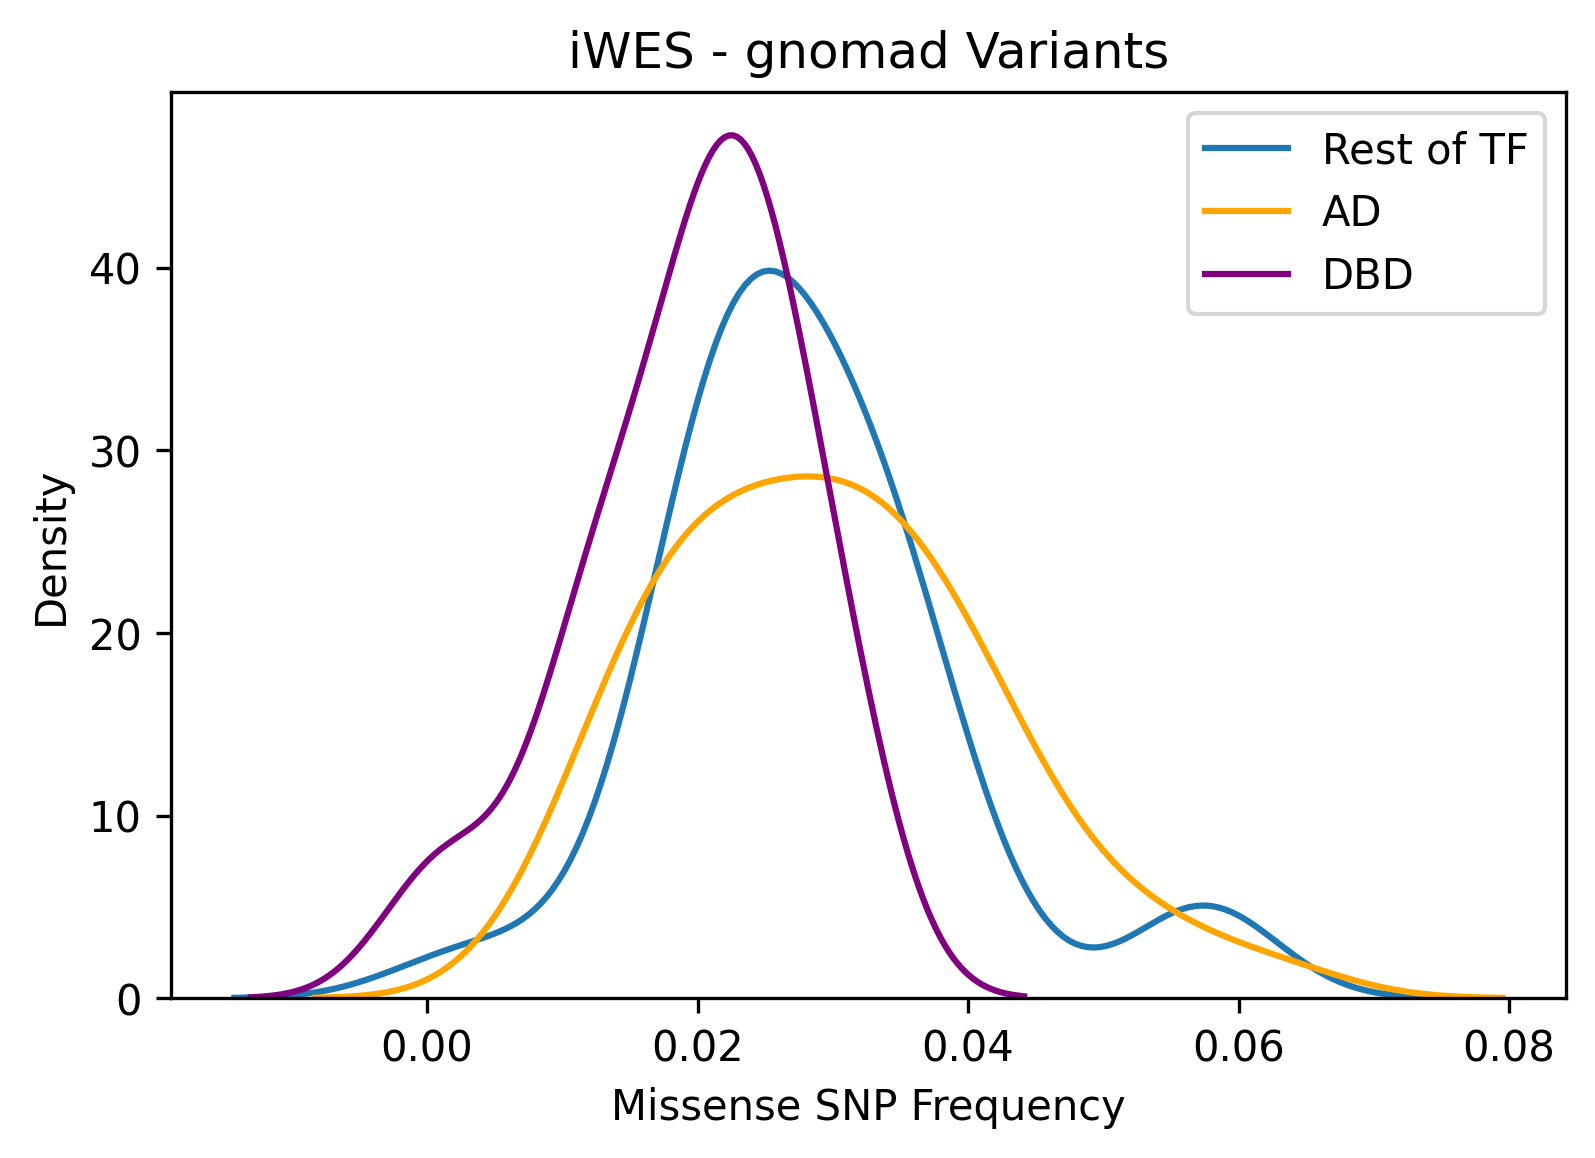

In [83]:
plt.figure(figsize = (6,4), dpi = 300);

rest_of_TF_prop = (outputs_with_gnomad_overlaps["TF_iWES-gnomad_missense"] - outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense"]) \
/ (outputs_with_gnomad_overlaps["TF_cds_length"] - outputs_with_gnomad_overlaps["AD_cds_length"])

sns.kdeplot(rest_of_TF_prop, label = "Rest of TF");
sns.kdeplot(outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense_prop"], color = "orange", label = "AD");
sns.kdeplot(outputs_with_gnomad_overlaps["DBD_iWES-gnomad_missense_prop"], color = "purple", label = "DBD");

plt.legend()
plt.xlabel("Missense SNP Frequency")
plt.title("iWES - gnomad Variants")

In [120]:
outputs_with_gnomad_overlaps

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,...,AD_iWES-gnomad_prop,DBD_iWES-gnomad_prop,TF_iWES-gnomad_missense,AD_iWES-gnomad_missense,DBD_iWES-gnomad_missense,TF_iWES-gnomad_missense_prop,AD_iWES-gnomad_missense_prop,DBD_iWES-gnomad_missense_prop,ADvsDBD_fisher_exact_p_vals,AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,...,0.017182,NaN,47,10,0,0.021820,0.017182,NaN,1.000000,1.000000
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,...,0.036630,0.011111,65,10,2,0.038484,0.036630,0.011111,0.136158,0.136158
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,...,0.021505,NaN,162,10,0,0.030682,0.021505,NaN,1.000000,1.000000
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,...,0.025641,NaN,58,3,0,0.020308,0.025641,NaN,1.000000,1.000000
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,...,0.044218,0.023810,115,39,9,0.031865,0.044218,0.023810,0.107095,0.107095
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,...,0.029167,NaN,39,7,0,0.021776,0.029167,NaN,1.000000,1.000000
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,...,0.037954,NaN,46,23,0,0.039519,0.037954,NaN,1.000000,1.000000
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,...,0.023188,0.030303,36,24,6,0.022599,0.023188,0.030303,0.612270,0.612270
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,...,0.024904,NaN,46,13,0,0.024691,0.024904,NaN,1.000000,1.000000
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,...,0.031414,0.012346,32,18,3,0.021903,0.031414,0.012346,0.148246,0.148246


In [93]:
Variant_analysis_helper_functions.add_fisher_p_vals_vs_control(outputs_with_gnomad_overlaps, "AD", "DBD", domain_descrip = "_iWES-gnomad")
outputs_with_gnomad_overlaps

[[10, 0], [572, 0]]
[[10, 2], [263, 178]]
[[10, 0], [455, 0]]
[[3, 0], [114, 0]]
[[39, 9], [843, 369]]
[[7, 0], [233, 0]]
[[23, 0], [583, 0]]
[[24, 6], [1011, 192]]
[[13, 0], [509, 0]]
[[18, 3], [555, 240]]
[[162, 0], [2430, 0]]
[[9, 0], [237, 0]]
[[12, 0], [258, 0]]
[[2, 0], [130, 0]]
[[7, 0], [293, 0]]
[[6, 1], [414, 35]]
[[32, 1], [1129, 86]]
[[18, 4], [396, 185]]
[[2, 2], [100, 178]]
[[31, 0], [860, 0]]
[[17, 0], [805, 0]]
[[27, 0], [1203, 0]]
[[18, 0], [582, 0]]
[[3, 14], [246, 568]]
[[7, 14], [260, 568]]
[[27, 4], [807, 227]]
[[10, 6], [308, 222]]
[[6, 4], [156, 176]]
[[22, 3], [527, 177]]
[[2, 1], [163, 380]]
[[14, 7], [442, 374]]
[[8, 3], [142, 177]]
[[3, 4], [339, 194]]
[[15, 0], [912, 0]]
[[185, 0], [5527, 39]]
[[4, 13], [236, 551]]
[[38, 1], [943, 44]]
[[8, 0], [475, 0]]
[[6, 5], [294, 202]]
[[13, 0], [497, 0]]
[[34, 0], [1025, 0]]
[[7, 7], [149, 218]]
[[11, 0], [277, 0]]
[[9, 7], [162, 221]]


,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,...,AD_iWES-gnomad_prop,DBD_iWES-gnomad_prop,TF_iWES-gnomad_missense,AD_iWES-gnomad_missense,DBD_iWES-gnomad_missense,TF_iWES-gnomad_missense_prop,AD_iWES-gnomad_missense_prop,DBD_iWES-gnomad_missense_prop,ADvsDBD_fisher_exact_p_vals,AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,0,0,...,0.017182,NaN,47,10,0,0.021820,0.017182,NaN,1.000000,1.000000
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,180,3,...,0.036630,0.011111,65,10,2,0.038484,0.036630,0.011111,0.136158,0.136158
2,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,0,0,...,0.021505,NaN,162,10,0,0.030682,0.021505,NaN,1.000000,1.000000
3,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,0,0,...,0.025641,NaN,58,3,0,0.020308,0.025641,NaN,1.000000,1.000000
4,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,378,23,...,0.044218,0.023810,115,39,9,0.031865,0.044218,0.023810,0.107095,0.107095
5,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,0,0,...,0.029167,NaN,39,7,0,0.021776,0.029167,NaN,1.000000,1.000000
6,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,0,0,...,0.037954,NaN,46,23,0,0.039519,0.037954,NaN,1.000000,1.000000
7,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,198,27,...,0.023188,0.030303,36,24,6,0.022599,0.023188,0.030303,0.612270,0.612270
8,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,0,0,...,0.024904,NaN,46,13,0,0.024691,0.024904,NaN,1.000000,1.000000
9,ERG,P11308,1461,131,0.089665,573,55,0.095986,243,7,...,0.031414,0.012346,32,18,3,0.021903,0.031414,0.012346,0.148246,0.148246


In [92]:
outputs_with_gnomad_overlaps[outputs_with_gnomad_overlaps["AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals"] < 0.05]

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,...,AD_iWES-gnomad_prop,DBD_iWES-gnomad_prop,TF_iWES-gnomad_missense,AD_iWES-gnomad_missense,DBD_iWES-gnomad_missense,TF_iWES-gnomad_missense_prop,AD_iWES-gnomad_missense_prop,DBD_iWES-gnomad_missense_prop,ADvsDBD_fisher_exact_p_vals,AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals


<Axes: xlabel='AD_missense', ylabel='Density'>

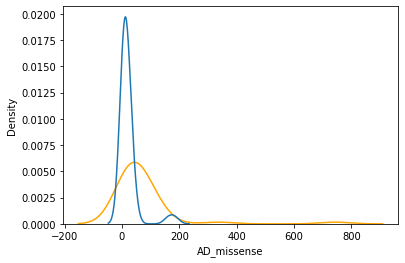

In [105]:
sns.kdeplot(outputs_with_gnomad_overlaps["AD_missense"], color = 'orange')
sns.kdeplot(outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense"])

In [108]:
np.mean(outputs_with_gnomad_overlaps["AD_missense"])

71.25

In [109]:
np.mean(outputs_with_gnomad_overlaps["AD_iWES-gnomad_missense"])

21.181818181818183

In [111]:
np.mean(outputs_with_gnomad_overlaps["AD_overlaps"])

50.06818181818182

In [116]:
outputs_with_gnomad_overlaps_with_AD_DBD = outputs_with_gnomad_overlaps.dropna()
outputs_with_gnomad_overlaps_with_AD_DBD.columns

Index(['gene-symbol', 'uniprotID', 'TF_cds_length', 'TF_missense',
       'TF_missense_prop', 'AD_cds_length', 'AD_missense', 'AD_missense_prop',
       'DBD_cds_length', 'DBD_missense', 'DBD_missense_prop', 'ENST',
       'AD_overlaps', 'DBD_overlaps', 'TF_overlaps', 'TF_iWES-gnomad',
       'AD_iWES-gnomad', 'DBD_iWES-gnomad', 'TF_iWES-gnomad_prop',
       'AD_iWES-gnomad_prop', 'DBD_iWES-gnomad_prop',
       'TF_iWES-gnomad_missense', 'AD_iWES-gnomad_missense',
       'DBD_iWES-gnomad_missense', 'TF_iWES-gnomad_missense_prop',
       'AD_iWES-gnomad_missense_prop', 'DBD_iWES-gnomad_missense_prop',
       'ADvsDBD_fisher_exact_p_vals',
       'AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals'],
      dtype='object')

In [117]:
outputs_with_gnomad_overlaps_with_AD_DBD[["gene-symbol", "uniprotID", 'AD_iWES-gnomad_missense_prop', 'AD_cds_length', 'DBD_iWES-gnomad_missense_prop', 'DBD_cds_length']]

,gene-symbol,uniprotID,AD_iWES-gnomad_missense_prop,AD_cds_length,DBD_iWES-gnomad_missense_prop,DBD_cds_length
1,ARX,Q96QS3,0.036630,273,0.011111,180
4,CAMTA2,O94983,0.044218,882,0.023810,378
7,ESR2,Q92731,0.023188,1035,0.030303,198
9,ERG,P11308,0.031414,573,0.012346,243
15,KMT2A,Q03164,0.014286,420,0.027778,36
16,MEF2C,Q06413,0.027562,1161,0.011494,87
17,MEIS2,O14770,0.043478,414,0.021164,189
18,MSX2,P35548,0.019608,102,0.011111,180
23,NFIA,Q12857,0.012048,249,0.024055,582
24,NFIX,Q14938,0.026217,267,0.024055,582


In [123]:
outputs_with_gnomad_overlaps.columns

Index(['gene-symbol', 'uniprotID', 'TF_cds_length', 'TF_missense',
       'TF_missense_prop', 'AD_cds_length', 'AD_missense', 'AD_missense_prop',
       'DBD_cds_length', 'DBD_missense', 'DBD_missense_prop', 'ENST',
       'AD_overlaps', 'DBD_overlaps', 'TF_overlaps', 'TF_iWES-gnomad',
       'AD_iWES-gnomad', 'DBD_iWES-gnomad', 'TF_iWES-gnomad_prop',
       'AD_iWES-gnomad_prop', 'DBD_iWES-gnomad_prop',
       'TF_iWES-gnomad_missense', 'AD_iWES-gnomad_missense',
       'DBD_iWES-gnomad_missense', 'TF_iWES-gnomad_missense_prop',
       'AD_iWES-gnomad_missense_prop', 'DBD_iWES-gnomad_missense_prop',
       'ADvsDBD_fisher_exact_p_vals',
       'AD_iWES-gnomadvsDBD_iWES-gnomad_fisher_exact_p_vals'],
      dtype='object')